In [ ]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input, TimeDistributed, BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import os
from keras.models import load_model
from keras.callbacks import Callback
import json
import io

In [ ]:
# instalar comet ml en caso que sea necesario
!pip install comet_ml
from comet_ml import Experiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.5/710.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.3/980.3 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.0
    Uninstalling python-box-7.3.0:
      Successfully uninstalled python-box-7.3.0


In [ ]:
# establecer semilla
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Levanto datos crudos por sujeto

In [ ]:
# Directorio de los datos
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset"

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset


In [ ]:
# levanto todos los datasets
cant_ds = 10
list_ds = []
for i in range(cant_ds):
  # ds = tf.data.Dataset.load("dataset_E1_sin_reposo_400_crudo_sub"+str(i))
  ds = tf.data.Dataset.load("dataset_E1_sin_reposo_crudo_sub"+str(i))
  list_ds.append(ds)

## Usando partición 1
Recordar que los sujetos de test son el 1 y el 7 (empezando desde el 0).

Voy a tomar para validar los sujetos 2 y 8

In [ ]:
def generar_particion1(list_ds):
  # Esta funcion recibe como entrada una lista con los folds, donde cada fold es un dataset,
  # y devuelve un conjunto de train, val y test:
  # test: fold 1 y 7, val: 2 y 8, train: resto.

  # Armo el conjunto de test
  ds_test = list_ds[1]
  # lo concateno con el 7
  ds_test = ds_test.concatenate(list_ds[7])

  # Armo el conjunto de validacion
  ds_val = list_ds[2]
  # lo concateno con el 8
  ds_val = ds_val.concatenate(list_ds[8])

  # Armo el conjunto de train
  ind_train = list(np.arange(10))
  ind_train.pop(1)
  ind_train.pop(6)

  # elimino los de val
  ind_train.pop(1)
  ind_train.pop(5)

  ind_train.pop(0)  # porque inicializo el dataset con este
  ds_train = list_ds[0]
  for i in ind_train:
    ds_train = ds_train.concatenate(list_ds[i])

  return ds_train, ds_val, ds_test

ds_train_base, ds_val_base, ds_test_base = generar_particion1(list_ds)  # le agrego base para poder usarlos al final sin modificaciones

# Levanto los datos crudos seq to seq

## Por repetición

In [ ]:
# Directorio de los datos
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset_x_rep"

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset_x_rep


In [ ]:
# levanto todos los datasets
cant_ds = 10  # esta es la cantidad de sujetos
cant_rep = 6
list_ds = []
for i in range(cant_ds):
  ds_reps = []
  for j in range(cant_rep):
    # ds_reps_j = tf.data.Dataset.load("dataset_E1_selected_sin_reposo_crudo_sub"+str(i)+"x_rep_fold_rep_"+str(j))
    ds_reps_j = tf.data.Dataset.load("dataset_E1_selected_con_reposo_crudo_sub"+str(i)+"x_rep_fold_rep_"+str(j))
    ds_reps.append(ds_reps_j)
  list_ds.append(ds_reps)

Primero tengo que unir los 6 folds de cada sujeto para armar los que son por repeticion.
En cada elemento de list_ds tengo 6 folds, de las diferentes repeticiones. Quiero unirlos.

In [ ]:
folds_rep = [[], [], [], [], [], []]

for i in list_ds:
  for j in range(len(i)):
    folds_rep[j].append(i[j])

In [ ]:
# por ahora lo hago hardcodeado para cada fold
fold0_rep = folds_rep[0]
fold1_rep = folds_rep[1]
fold2_rep = folds_rep[2]
fold3_rep = folds_rep[3]
fold4_rep = folds_rep[4]
fold5_rep = folds_rep[5]

# fold 0
ds_test_base = fold0_rep[0]
for i in range(1, len(fold0_rep)):
  ds_test_base = ds_test_base.concatenate(fold0_rep[i])

# fold 1
ds_val_base = fold1_rep[0]
for i in range(1, len(fold1_rep)):
  ds_val_base = ds_val_base.concatenate(fold1_rep[i])

# fold 2
ds2_all = fold2_rep[0]
for i in range(1, len(fold2_rep)):
  ds2_all = ds2_all.concatenate(fold2_rep[i])

# fold 3
ds3_all = fold3_rep[0]
for i in range(1, len(fold3_rep)):
  ds3_all = ds3_all.concatenate(fold3_rep[i])

# fold 4
ds4_all = fold4_rep[0]
for i in range(1, len(fold4_rep)):
  ds4_all = ds4_all.concatenate(fold4_rep[i])

# fold 5
ds5_all = fold5_rep[0]
for i in range(1, len(fold5_rep)):
  ds5_all = ds5_all.concatenate(fold5_rep[i])

Voy a usar el 0 para test, el 1 para val y uno el resto para el train.

In [ ]:
ds2_all = ds2_all.concatenate(ds3_all)
ds2_all = ds2_all.concatenate(ds4_all)

# lo llamo ds_train
ds_train_base = ds2_all.concatenate(ds5_all)


Creo un directorio para guardar los modelos y otras cosas relativos al entrenamiento de este modelo.

# Preparación de datos

In [ ]:
# elijo el directorio donde quiero guardar los resultados del experimento actual
nombre_exp = "ronda3_RNN_E1_crudo_sin_reposo_100%_650_stride5_x_sujeto_seq_vector"
ruta_experimento = "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/" + nombre_exp
os.makedirs(ruta_experimento, exist_ok=True) # me fijo si existe, si no, lo creo
# os.chdir(ruta_experimento) # me situo en el directorio

In [ ]:
for x, y in ds_train_base.take(1):
  input_shape = x.shape
  label_shape = y.shape
  label = y
print('Input shape:', input_shape)
print('Label shape:', label_shape)
print('Label', label)
# num_classes = 23
num_classes = 12

Input shape: (650, 16)
Label shape: ()
Label tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
# Función para convertir etiquetas a formato one-hot
def one_hot_encode(features, label):
    label = tf.one_hot(label, depth=num_classes)
    return features, label

In [ ]:
# funciones de acondicionamiento de los datos
BATCH_SIZE = 16
def preparar_ds(ds):
  ds = ds.map(one_hot_encode) # paso las clases a una codificacion one hot
  ds = ds.shuffle(buffer_size=ds.cardinality()) # hago un shuffle de los datos
  ds = ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) # armo batches y cargo en memoria la cantidad de datos optima, listos para ser utilizados
  return ds

ds_train = preparar_ds(ds_train_base)
ds_val = preparar_ds(ds_val_base)
ds_test = preparar_ds(ds_test_base)

# Diseño e implementación de RNN

## Arquitectura simple
Solo una capa recurrente.

In [ ]:
input_shape = (650, 16)
# Definir el modelo con return_sequences=True
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(48, input_shape=input_shape, return_sequences=True),  # Devuelve la secuencia completa
    tf.keras.layers.GlobalAveragePooling1D(),  # Promedia las salidas de la secuencia
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Capa de salida para la clasificación
])
lr = 0.0001
# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 650, 48)             │          12,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 48)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             588 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,068 (51.05 KB)

 Trainable params: 13,068 (51.05 KB)

 Non-trainable params: 0 (0.00 B)

## Arquitectura más compleja
Le agrego una capa densa y aumento la cantidad de neuronas de la recurrente.

In [ ]:
input_shape = (400, 16)
# Definir el modelo con return_sequences=True
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(72, input_shape=input_shape, return_sequences=True),  # Devuelve la secuencia completa
    # tf.keras.layers.GlobalAveragePooling1D(),  # Promedia las salidas de la secuencia
    tf.keras.layers.TimeDistributed(Dense(64, activation='relu')),
    tf.keras.layers.GlobalAveragePooling1D(),  # Promedia las salidas de la secuencia
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Capa de salida para la clasificación
])
lr = 0.0001
# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 72)           25632     
                                                                 
 time_distributed (TimeDist  (None, 400, 64)           4672      
 ributed)                                                        
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_1 (Dense)             (None, 12)                780       
                                                                 
Total params: 31084 (121.42 KB)
Trainable params: 31084 (121.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Si entreno el modelo por primera vez

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{self.epoch_offset + epoch + 1}.keras')
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Crear el callback
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento)

# Entrenar el modelo
history = model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=[saver])

Epoch 1/10
2409/2412 [============================>.] - ETA: 0s - loss: 1.5788 - accuracy: 0.4640Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_crudo_sin_reposo_100%_400_stride5_x_sujeto_seq_vector_nueva_arq/model_epoch_1.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_crudo_sin_reposo_100%_400_stride5_x_sujeto_seq_vector_nueva_arq/complete_history.json
2412/2412 [==============================] - 87s 22ms/step - loss: 1.5784 - accuracy: 0.4641 - val_loss: 1.6682 - val_accuracy: 0.4676
Epoch 2/10
2412/2412 [==============================] - ETA: 0s - loss: 0.9491 - accuracy: 0.6674Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_crudo_sin_reposo_100%_400_stride5_x_sujeto_seq_vector_nueva_arq/model_epoch_2.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_experimentos

<Axes: xlabel='Epoch'>

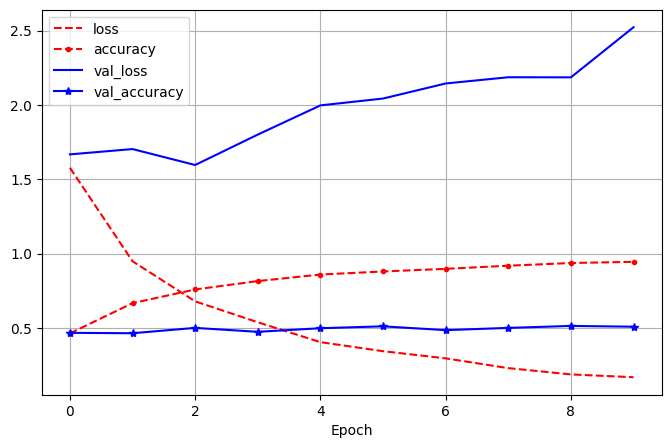

In [ ]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(history.history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
# plt.savefig("evolucion_entrenamiento.png")

## Si quiero retomar el entrenamiento

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_25.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

# AJUSTAR LA EPOCA EN LA QUE RETOMO EL ENTRENAMIENTO
# Continuar el entrenamiento desde la última época. En initial_epoch pongo el numero de la ultima epoca entrenada
model.fit(ds_train, validation_data=ds_val, epochs=30, initial_epoch=25, callbacks=[saver])

Epoch 26/30
2411/2412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8186 - loss: 0.5251Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_crudo_sin_reposo_100%_400_stride5_x_sujeto_seq_vector_nueva_arq/model_epoch_26.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_crudo_sin_reposo_100%_400_stride5_x_sujeto_seq_vector_nueva_arq/complete_history.json
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 171s 62ms/step - accuracy: 0.8186 - loss: 0.5251 - val_accuracy: 0.4659 - val_loss: 1.8704
Epoch 27/30
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8283 - loss: 0.5077Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_crudo_sin_reposo_100%_400_stride5_x_sujeto_seq_vector_nueva_arq/model_epoch_27.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_experimentos_3/modelos/ronda3_RNN_E1_cr

## Si el modelo está entrenado

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# ELIJO QUE EPOCA QUIERO USAR, PUEDO MIRAR LA GRAFICA Y ELEGIR LA MEJOR
# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_14.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

<Axes: xlabel='Epoch'>

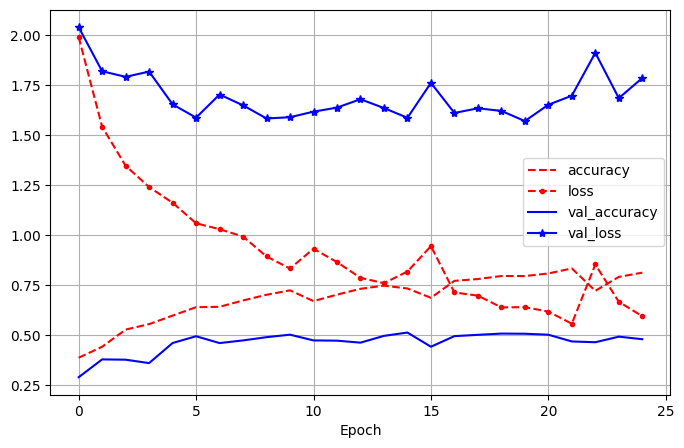

In [ ]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
# plt.savefig("evolucion_entrenamiento.png")

# Adaptación para hacer los evaluate
Para ejecutar esta parte tengo que tener el modelo entrenado y los dataset base cargados en memoria. Si el modelo ya está entrenado tengo que ejecutar la celda correspondiente.

## Cálculo de predicciones

In [ ]:
# armo batches en los conjuntos para poder realizar predicciones
ds_train_batch = ds_train_base.batch(16)
ds_val_batch = ds_val_base.batch(16)
ds_test_batch = ds_test_base.batch(16)

In [ ]:
# Obtener las predicciones en 1hot
y_pred_train_1hot = model.predict(ds_train_batch)
y_pred_val_1hot = model.predict(ds_val_batch)
y_pred_test_1hot = model.predict(ds_test_batch)

1081/1081 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step


Se puede ver que las predicciones no quedaron organizadas en batches, pero sí devuelven un vector codificado en one hot.

In [ ]:
def onehot2numerical(y_pred):
  # Convertir de one-hot a clases numéricas las predicciones
  y_clases = tf.argmax(y_pred, axis=-1)
  # Convertir a numpy si es necesario
  y_clases_numpy = y_clases.numpy()
  return y_clases_numpy

y_pred_train = onehot2numerical(y_pred_train_1hot)
y_pred_val = onehot2numerical(y_pred_val_1hot)
y_pred_test = onehot2numerical(y_pred_test_1hot)

## Extracción de etiquetas reales

In [ ]:
def extraer_etiquetas_ds(ds):
  y_train_true_list = []
  for x, y in ds: # dataset_with_classes ds_train
    # print(y.shape)
    y_train_true_list.append(y.numpy())
  return y_train_true_list

y_true_train_list = extraer_etiquetas_ds(ds_train_base)
y_true_val_list = extraer_etiquetas_ds(ds_val_base)
y_true_test_list = extraer_etiquetas_ds(ds_test_base)

In [ ]:
y_true_train_array = np.array(y_true_train_list)
y_true_val_array = np.array(y_true_val_list)
y_true_test_array = np.array(y_true_test_list)

print(y_true_train_array.shape)

(17288,)


In [ ]:
# Visualizacion de ejemplo
y_true_train_list[2]

# Matrices de confusión

In [ ]:
os.chdir(ruta_experimento) # me situo en el directorio

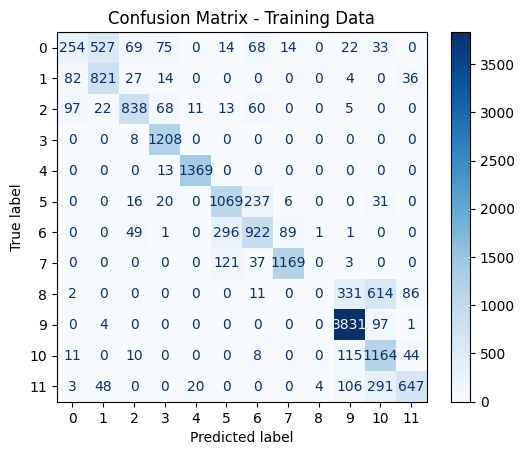

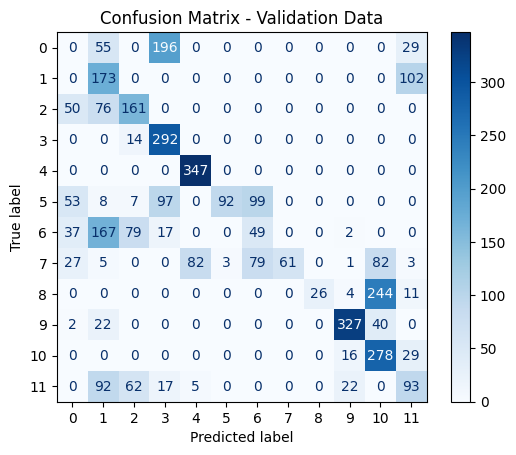

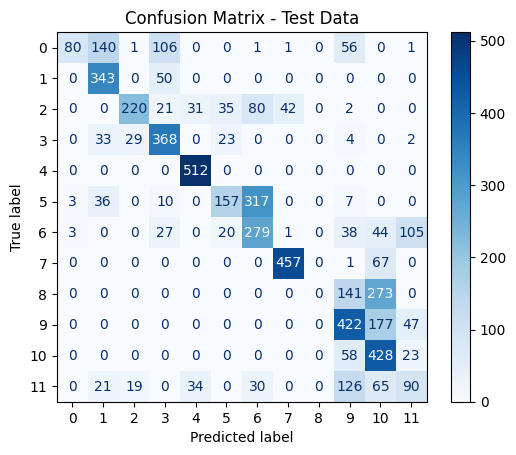

In [ ]:
# Generar matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_true_train_array, y_pred_train)
ConfusionMatrixDisplay(conf_matrix_train).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Training Data')
plt.savefig('train.png')
plt.show()

# Generar matriz de confusión para el conjunto de validación
conf_matrix_val = confusion_matrix(y_true_val_array, y_pred_val)
ConfusionMatrixDisplay(conf_matrix_val).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.savefig('val.png')
plt.show()

# para test

# Generar matriz de confusión para el conjunto de entrenamiento
conf_matrix_test = confusion_matrix(y_true_test_array, y_pred_test)
ConfusionMatrixDisplay(conf_matrix_test).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.savefig('test.png')
plt.show()

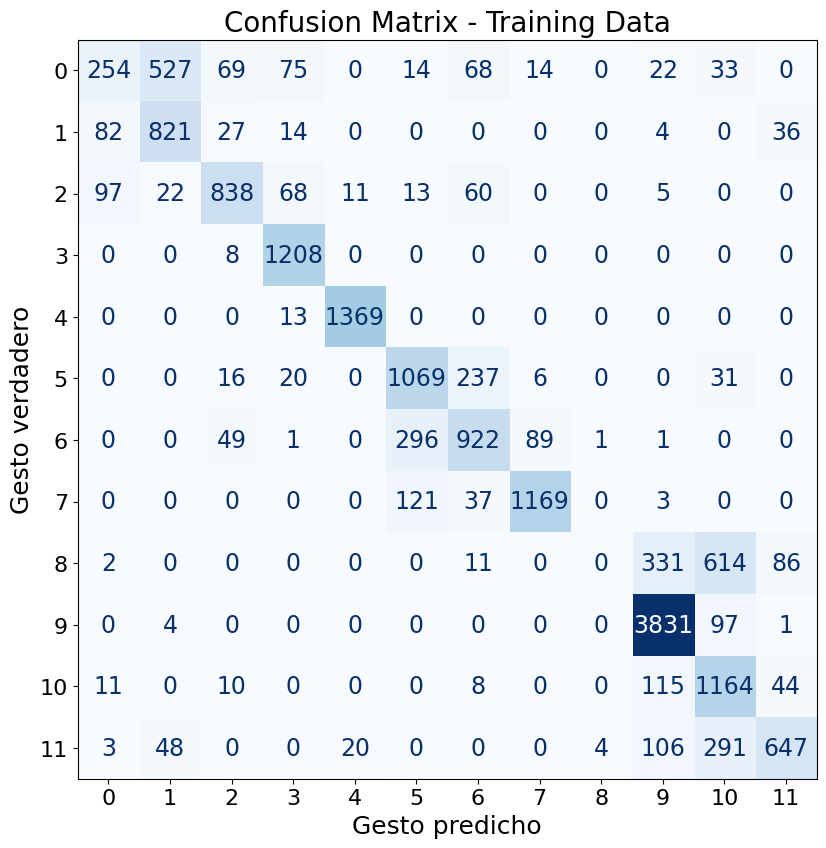

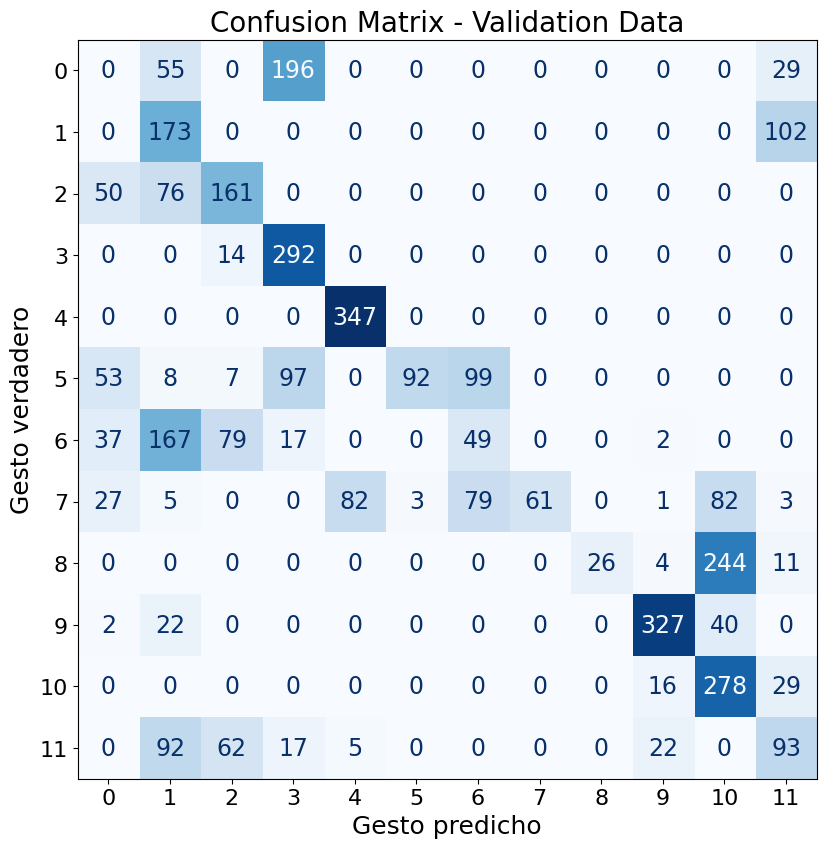

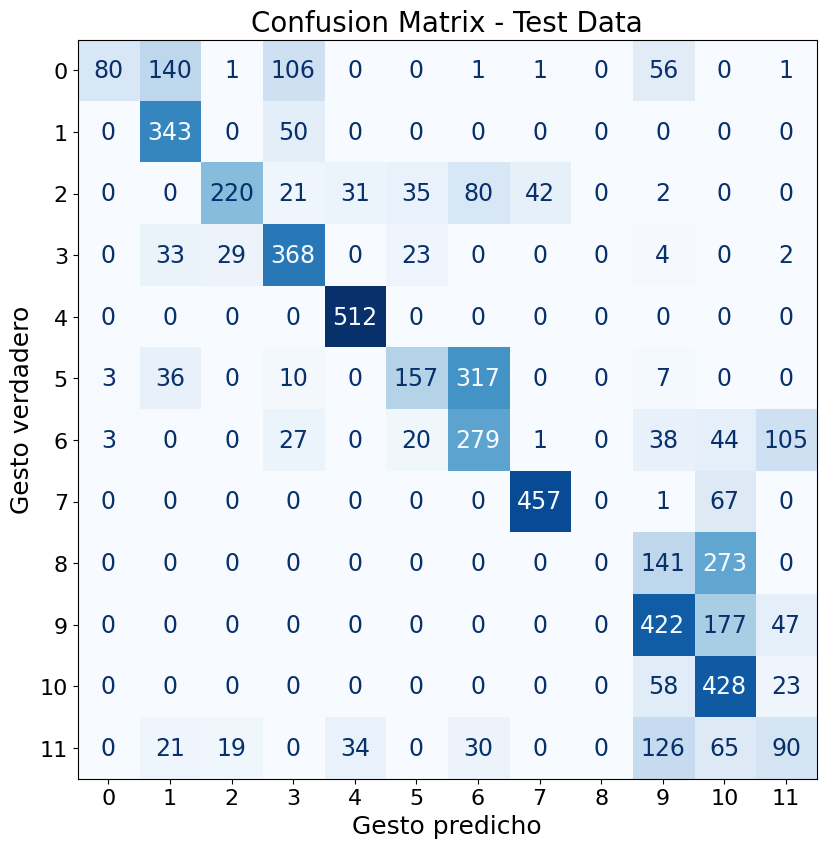

In [ ]:
def generar_matriz_confusion_personalizada(y_true, y_pred, title, ruta_guardar, decimales=2, mostrar=True):
    """
    Genera una matriz de confusión personalizada, normalizada o no, la guarda y opcionalmente la muestra.

    Args:
        y_true (array-like): Etiquetas verdaderas.
        y_pred (array-like): Etiquetas predichas.
        title (str): Título de la figura.
        ruta_guardar (str): Ruta para guardar la imagen.
        decimales (int, optional): Cantidad de decimales para redondear la matriz. Default: 2.
        mostrar (bool, optional): Si True, muestra la figura. Default: True.
    """
    try:
        # Obtener las clases únicas de las etiquetas reales
        classes = np.unique(y_true)

        # Generar la matriz de confusión
        conf_matrix = confusion_matrix(y_true, y_pred, normalize=None, labels=classes)

        # Crear la figura
        fig, ax = plt.subplots(figsize=(12.8, 9.6))

        # Crear y personalizar el display
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)  # Quitar la barra de color

        # Personalización de ejes y etiquetas
        disp.ax_.set_xlabel('Gesto predicho', fontsize=18)
        disp.ax_.set_ylabel('Gesto verdadero', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        plt.xticks(rotation=0)  # Asegurar que las etiquetas del eje X sean horizontales

        # Personalizar el tamaño de los números en la matriz
        for text in disp.ax_.texts:
            text.set_fontsize(17)

        # Título
        plt.title(title, fontsize=20)

        # Guardar y opcionalmente mostrar
        plt.savefig(ruta_guardar, bbox_inches='tight')
        if mostrar:
            plt.show()
        plt.close(fig)
    except Exception as e:
        print(f"Error al generar la matriz de confusión: {e}")

# Conjunto de entrenamiento
generar_matriz_confusion_personalizada(y_true_train_array, y_pred_train,
                                       'Confusion Matrix - Training Data',
                                       'train_confusion_matrix.pdf')

# Conjunto de validación
generar_matriz_confusion_personalizada(y_true_val_array, y_pred_val,
                                       'Confusion Matrix - Validation Data',
                                       'val_confusion_matrix.pdf')

# Conjunto de prueba
generar_matriz_confusion_personalizada(y_true_test_array, y_pred_test,
                                       'Confusion Matrix - Test Data',
                                       'test_confusion_matrix.pdf')



Accuracy en entrenamiento: 0.8124


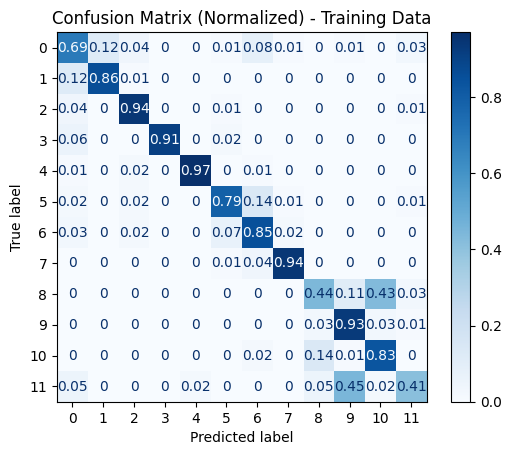

Accuracy en validación: 0.5009


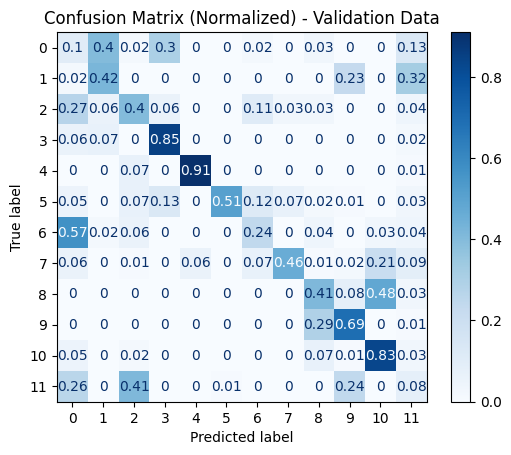

Accuracy en test: 0.5435


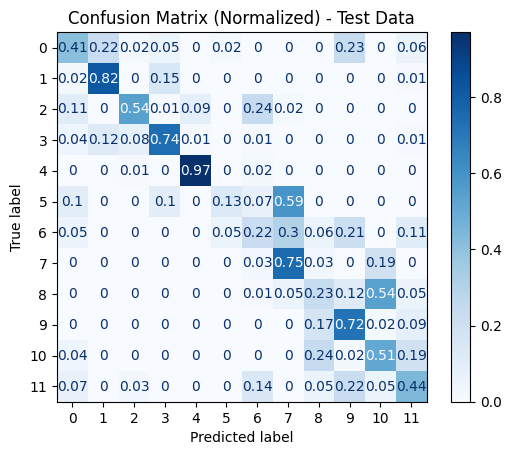

In [ ]:
# Función para generar y guardar la matriz de confusión con proporciones redondeadas
def generar_matriz_confusion_normalizada(y_true, y_pred, title, ruta_guardar, decimales=2):
    # Generar la matriz de confusión normalizada (por clase)
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

    # Redondear la matriz a la cantidad de decimales especificados
    conf_matrix = np.round(conf_matrix, decimals=decimales)

    # Crear el display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Graficar
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)

    # Guardar la figura
    plt.savefig(ruta_guardar)
    plt.show()

# Función para calcular y mostrar el accuracy
def calcular_accuracy(y_true, y_pred, nombre_conjunto):
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy en {nombre_conjunto}: {accuracy:.4f}')
    return accuracy

# Para el conjunto de entrenamiento
accuracy_train = calcular_accuracy(y_true_train_array, y_pred_train, 'entrenamiento')
generar_matriz_confusion_normalizada(y_true_train_array, y_pred_train, 'Confusion Matrix (Normalized) - Training Data', 'train_normalized.png')

# Para el conjunto de validación
accuracy_val = calcular_accuracy(y_true_val_array, y_pred_val, 'validación')
generar_matriz_confusion_normalizada(y_true_val_array, y_pred_val, 'Confusion Matrix (Normalized) - Validation Data', 'val_normalized.png')

# Para el conjunto de test
accuracy_test = calcular_accuracy(y_true_test_array, y_pred_test, 'test')
generar_matriz_confusion_normalizada(y_true_test_array, y_pred_test, 'Confusion Matrix (Normalized) - Test Data','test_normalized.png')


Accuracy en entrenamiento: 0.7689


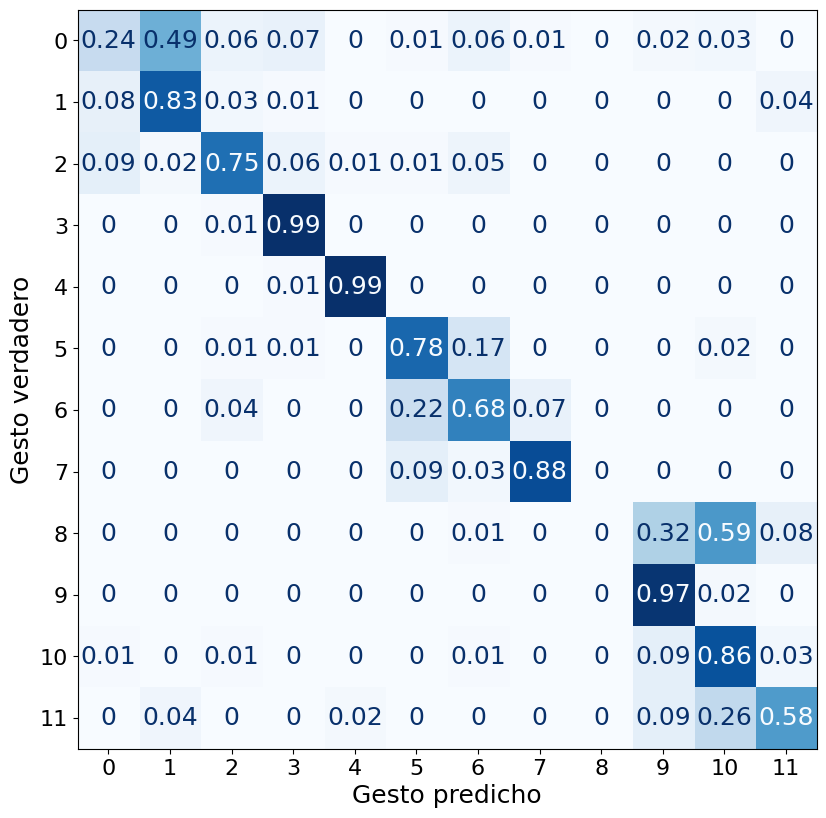

Accuracy en validación: 0.4952


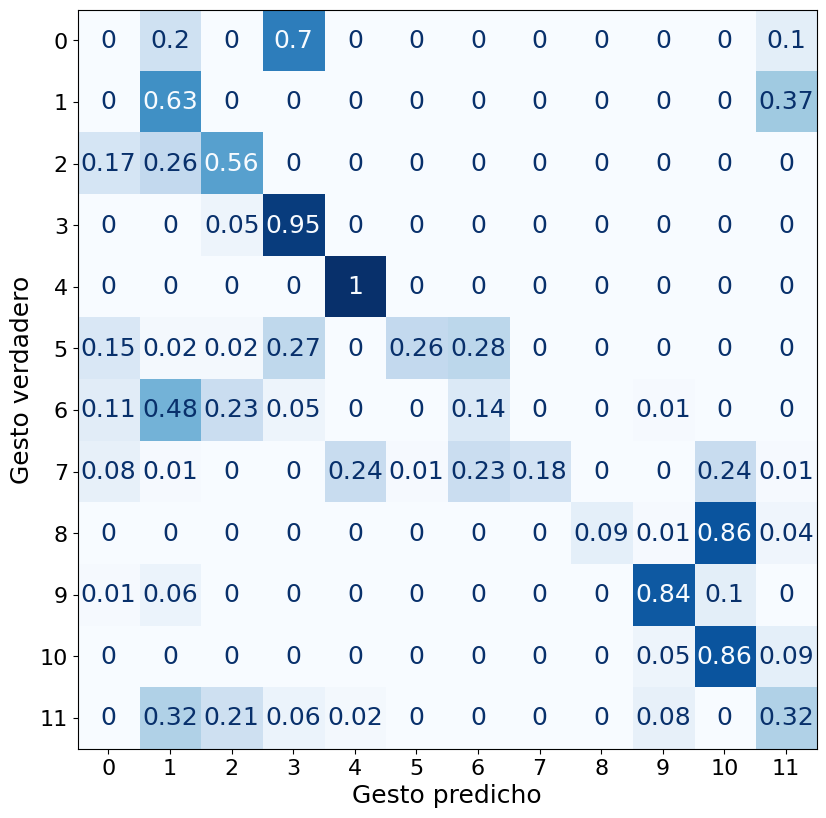

Accuracy en test: 0.5880


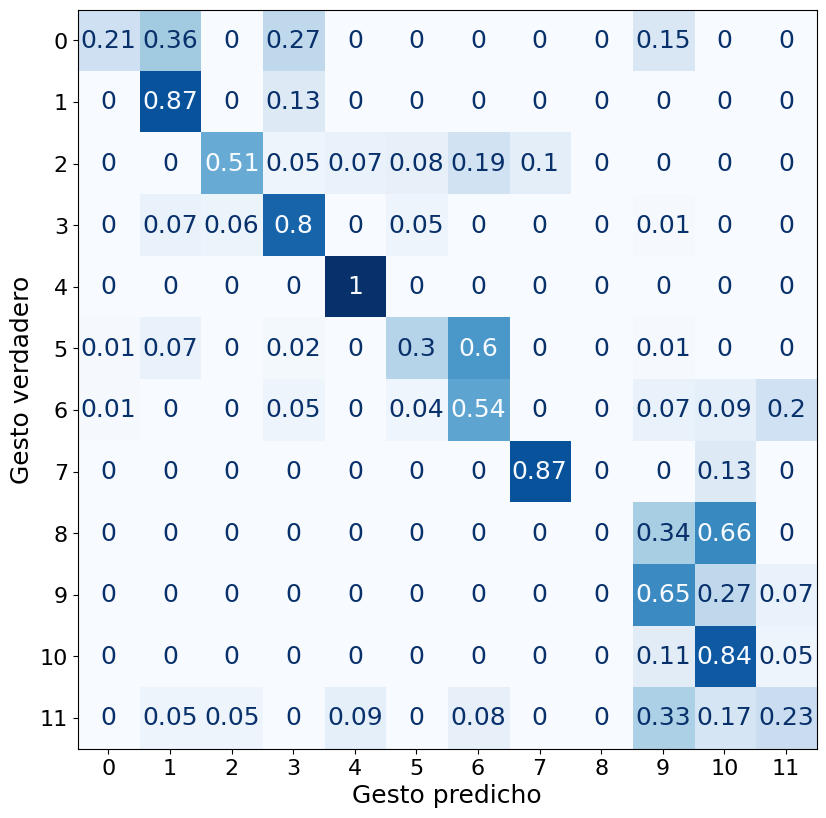

In [ ]:
def generar_matriz_confusion_normalizada(y_true, y_pred, title, ruta_guardar, decimales=2, mostrar=True):
    """
    Genera una matriz de confusión normalizada, la guarda y opcionalmente la muestra.

    Args:
        y_true (array-like): Etiquetas verdaderas.
        y_pred (array-like): Etiquetas predichas.
        title (str): Título de la figura.
        ruta_guardar (str): Ruta para guardar la imagen.
        decimales (int, optional): Cantidad de decimales para redondear la matriz. Default: 2.
        mostrar (bool, optional): Si True, muestra la figura. Default: True.
    """
    try:
        # Obtener las clases únicas de las etiquetas reales
        classes = np.unique(y_true)

        # Generar la matriz de confusión normalizada
        conf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=classes)

        # Redondear la matriz
        conf_matrix = np.round(conf_matrix, decimals=decimales)

        # Crear la figura
        fig, ax = plt.subplots(figsize=(12.8, 9.6))

        # Crear y personalizar el display
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)  # Quitar la barra de color

        # Personalización de ejes y etiquetas
        disp.ax_.set_xlabel('Gesto predicho', fontsize=18)
        disp.ax_.set_ylabel('Gesto verdadero', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        plt.xticks(rotation=0)  # Etiquetas del eje X horizontales

        # Personalizar el tamaño de los números en la matriz
        for text in disp.ax_.texts:
            text.set_fontsize(18)

        # Título
        # plt.title(title, fontsize=20)

        # Guardar la figura
        plt.savefig(ruta_guardar, bbox_inches='tight')

        # Mostrar la figura si es necesario
        if mostrar:
            plt.show()
        plt.close(fig)
    except Exception as e:
        print(f"Error al generar la matriz de confusión: {e}")


def calcular_accuracy(y_true, y_pred, nombre_conjunto):
    """
    Calcula y muestra el accuracy para un conjunto de datos.

    Args:
        y_true (array-like): Etiquetas verdaderas.
        y_pred (array-like): Etiquetas predichas.
        nombre_conjunto (str): Nombre del conjunto (e.g., entrenamiento, validación, prueba).
    """
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy en {nombre_conjunto}: {accuracy:.4f}')
    return accuracy


# Conjunto de entrenamiento
accuracy_train = calcular_accuracy(y_true_train_array, y_pred_train, 'entrenamiento')
generar_matriz_confusion_normalizada(y_true_train_array, y_pred_train,
                                     'Confusion Matrix (Normalized) - Training Data',
                                     'train_normalized.pdf',
                                     mostrar=True)

# Conjunto de validación
accuracy_val = calcular_accuracy(y_true_val_array, y_pred_val, 'validación')
generar_matriz_confusion_normalizada(y_true_val_array, y_pred_val,
                                     'Confusion Matrix (Normalized) - Validation Data',
                                     'val_normalized.pdf',
                                     mostrar=True)

# Conjunto de prueba
accuracy_test = calcular_accuracy(y_true_test_array, y_pred_test, 'test')
generar_matriz_confusion_normalizada(y_true_test_array, y_pred_test,
                                     'Confusion Matrix (Normalized) - Test Data',
                                     'test_normalized.pdf',
                                     mostrar=True)


# Guardar experimento en Comet

In [ ]:
# Guardar resumen en una cadena de texto para guardarlo en Comet
stream = io.StringIO()
model.summary(print_fn=lambda x: stream.write(x + '\n'))
summary_str = stream.getvalue()
stream.close()

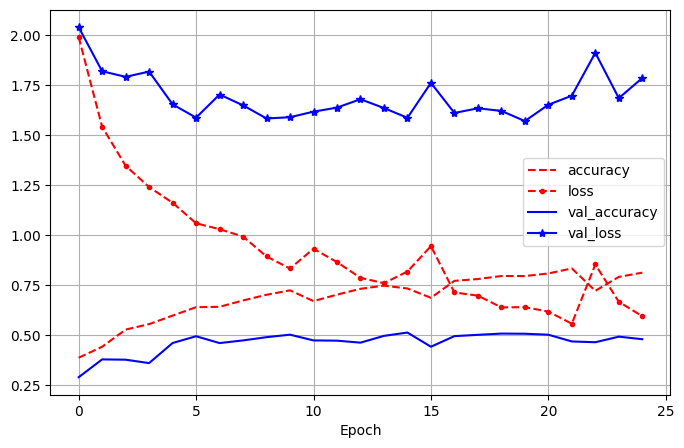

In [ ]:
nombre = nombre_exp
joblib.dump(model, nombre + '.pkl')
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
plt.savefig("evolucion_entrenamiento.png")

In [ ]:
API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
              project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
              auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['ronda3', 'sin_reposo', '12_gestos','seq_vector', 'x_sujeto']) # Tags,'particion_1'

exp.log_metric("test_accuracy_rank", accuracy_test)
exp.log_metric("val_accuracy_rank", accuracy_val)
exp.log_metric("train_accuracy_rank", accuracy_train)

exp.log_parameter("batch_size", BATCH_SIZE)
exp.log_parameter("stride", 5)
exp.log_parameter("largo_secuencia", 650)
exp.log_parameter("stop_epoch", 14)
exp.log_parameter("sample_weight", 0)
exp.log_parameter("porcentaje_label", 100)
exp.log_parameter("cantidad_gestos", 12)
exp.log_parameter("particion_datos", 1)
exp.log_parameter("lr", format(lr, ".8g"))

# Guardar la imagen en Comet
exp.log_image("evolucion_entrenamiento.png")

exp.log_image('train.png')
exp.log_image('val.png')
exp.log_image('test.png')

exp.log_image('train_normalized.pdf')
exp.log_image('val_normalized.pdf')
exp.log_image('test_normalized.pdf')

exp.log_text("Seq to vector. sin reposo, secuencia 650\n")   # Comentario del experimento
exp.log_text("Model Summary:\n" + summary_str)
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, sklearn, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/2a146f6928a84c408fee608c9256e116

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 